## Contents

Part1: Exploratory Data Analysis(EDA):  
1)Analysis of the features.
</br></br>
2)Finding any relations or trends considering multiple features.
</br></br>
Part2: Feature Engineering and Data Cleaning:    
1)Adding any few features.
</br></br>
2)Removing redundant features.
</br></br>
3)Converting features into suitable form for modeling.
</br></br>
Part3: Predictive Modeling  
1)Running Basic Algorithms.
</br></br>
2)Cross Validation.
</br></br>
3)Ensembling.
</br></br>
4)Important Features Extraction.

### Part1: Exploratory Data Analysis(EDA)

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
submission_path = 'data/gender_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 결측치 확인
train.isnull().sum()  # checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- age, cabin, embarked 결측치 존재
- 이후에 수정 필요

__생존자 확인__
1. train 생존자 pie그래프 

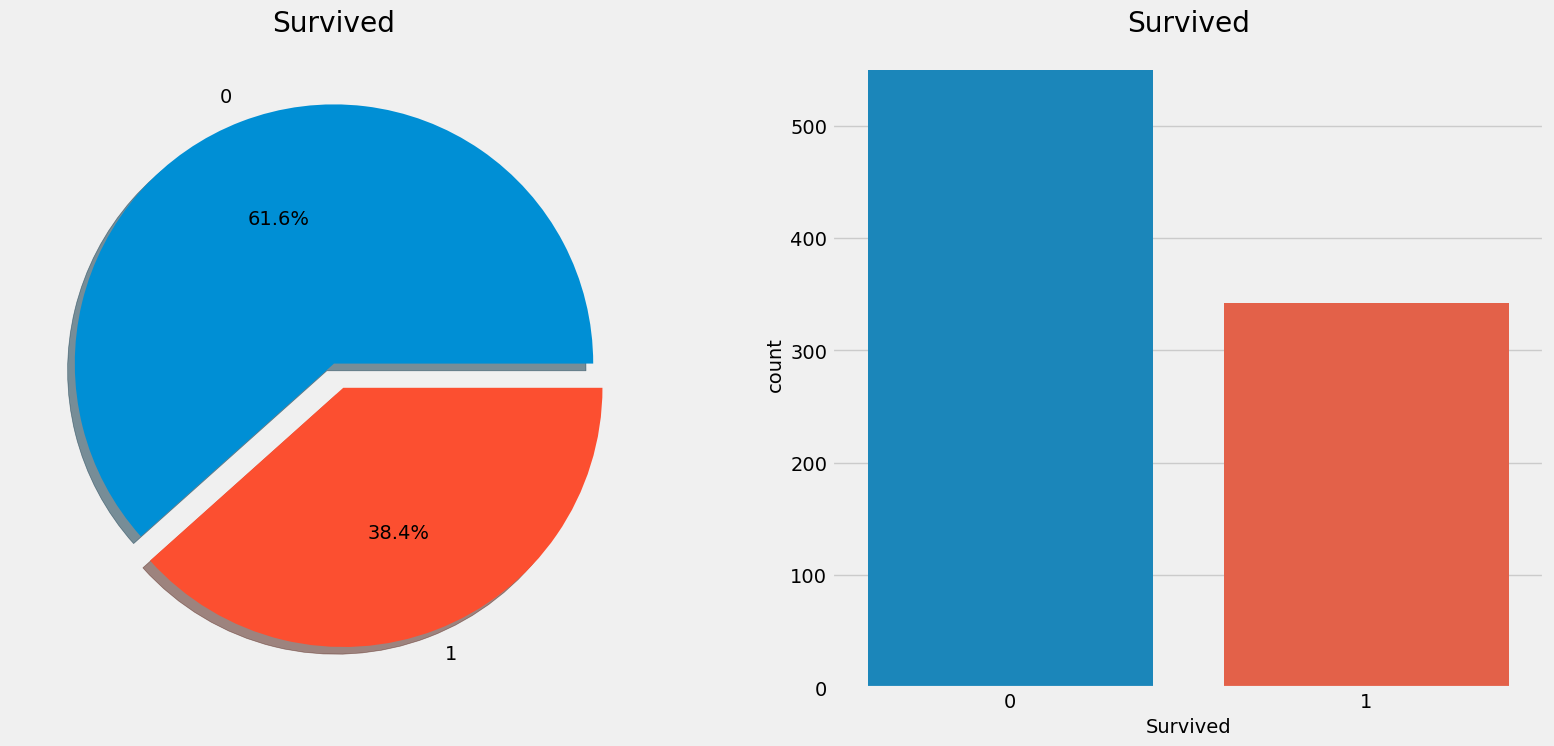

In [6]:
f, ax = plt.subplots(1,2,figsize=(18,8))
train['Survived'].value_counts().plot.pie(explode=[0,0.1], # 원의 틈이 얼마나 벌어져있는지
                                          autopct='%1.1f%%',
                                          ax=ax[0],
                                          shadow=True)  # 그림자 존재재
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

이 증거는 많은 승객이 생존하지 못했음을 보여준다. 

891명의 승객 중, 약 350 명 정도만 생존

다른 피쳐들을 사용해서 생존률을 검토해봐야 한다. 

### Types Of Features 
1. Categorical Features : 
    - 범주형 피쳐
2. Ordinal Features :
    - 범주형 데이터의 일종
    - 크고 작음의 구분이 있는 경우 ordinal features라고 함
3. Continous Feature:
    - 연속형 피쳐쳐

### Analysing The Features

### Sex -> Categorical Feature

In [7]:
train.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

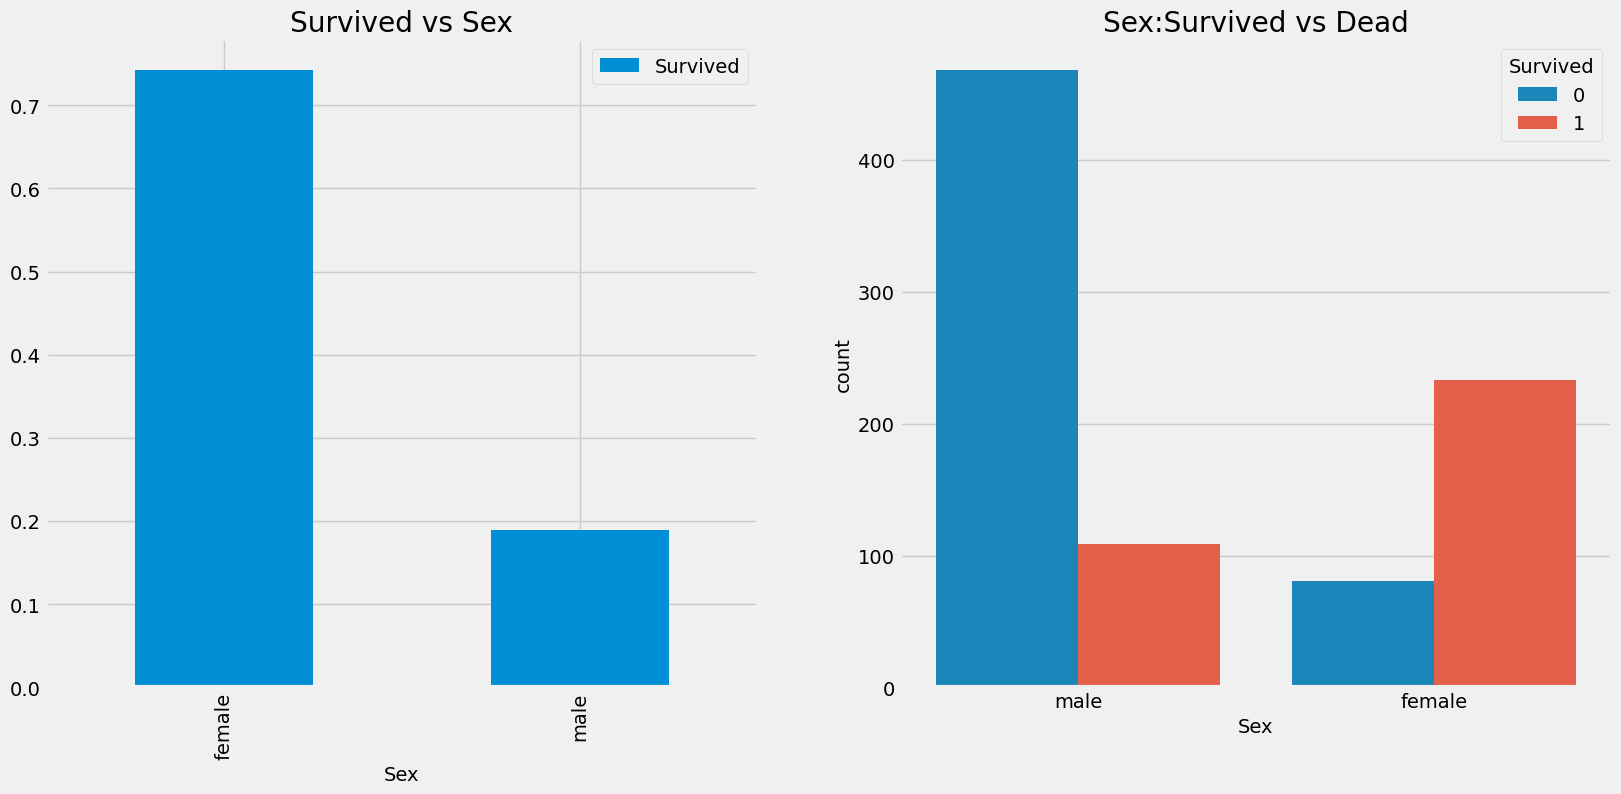

In [8]:
f, ax = plt.subplots(1,2,figsize = (18,8))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(data=train,x='Sex', hue='Survived', ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

This looks intersting. The number of men on the ship is lot more than the number of women. Still the number of women saved is almost twice number of males saved is twice the number of male saved. The survival rates for a women on the shop is around 75% while that for men in around 18-19%.

This looks to be a very important feature for modeling. But is it the best?? Lets check other features.

### Pclass -> Ordinal Feature 

ordinal feature = 순서 피쳐


In [9]:
'''
crosstab은 범주형 데이터를 교차로 비교할 수 있는 기능
margin = 전체값
normalize = 비율화
style.background_gradient = 빈도에 따른 색 표현
'''
pd.crosstab(train.Pclass, train.Survived, margins=True, normalize =True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,0.089787,0.152637,0.242424
2,0.108866,0.097643,0.206510
3,0.417508,0.133558,0.551066
All,0.616162,0.383838,1.000000


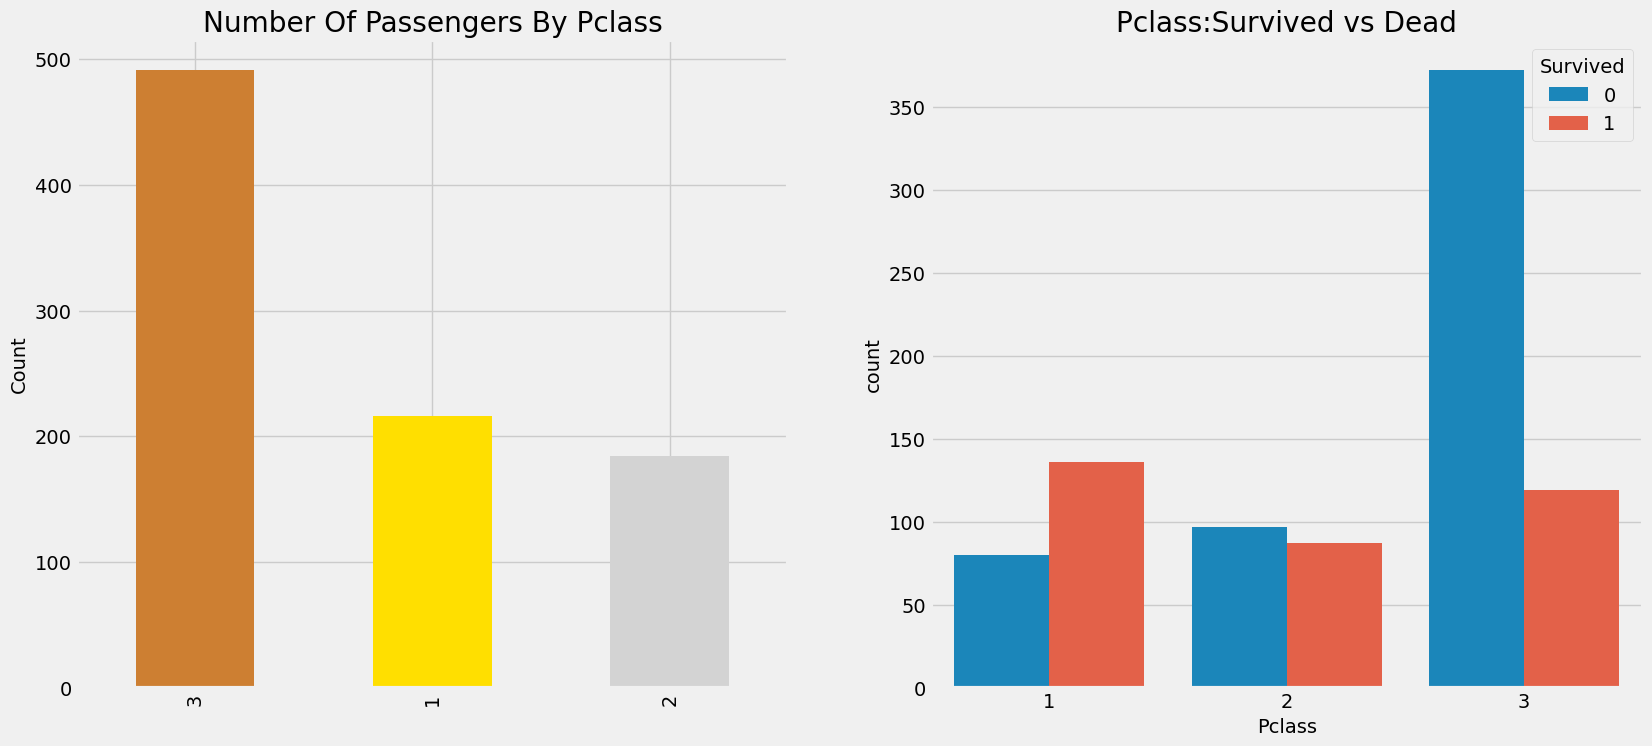

In [17]:
'''
(1,2)의 sublot을 만들고 
pclass에 따라서 죽은사람과 산 사람이 차이가 나는지 막대그래프를 통해 확인해라
'''
f, ax = plt.subplots(1,2, figsize = (18,8))
train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0]) #pclass 각 등급별 사람 수 
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(data=train, x='Pclass', hue='Survived', ax=ax[1]) #pclass에 따른 생존률
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

people say __Money Can't Buy Eveerything.__ But we can clearly see that Passengers Of Pclass 1 were given a very high priority while rescue. Even though the number of Passengers in Pclass 3 were in Pclass 3 were a lot higher, still the number of survival from them is very low, somewhere around 25%. 

For Pclass 1% survived is around 63% while for Pclass2 is around 48%. So money and status matters. Such a materialistic world.

Lets Dive in little vit more and check for other intersting observations Lets check survival rate with __Sex and Pclass__ Together.

In [ ]:
dfsdfsdfsdfsdfsd